In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import missingno as msno
from collections import Counter
from itertools import chain, combinations
import sklearn as sk
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, make_scorer

In [3]:
data = pd.read_csv("imputed_dataset_4.csv", engine='python').drop(['Unnamed: 0'], axis = 1)
dep_data = data.copy()

In [4]:
dep_num = np.array([12, 11, 10, 4])
no_dep_num = np.setdiff1d(range(13), dep_num)

dep_data[['prim_diag', 'secd_diag']] = dep_data[['prim_diag', 'secd_diag']].replace(list(no_dep_num), 0)
dep_data[['prim_diag', 'secd_diag']] = dep_data[['prim_diag', 'secd_diag']].replace(list(dep_num), 1)

In [5]:
full = data.dropna(axis = 0, how = 'any')
dep = [x for x in data.columns if 'dep' in x or 'diag' in x or 'panic' in x]
dep_data['dep'] = dep_data['secd_diag'] + dep_data['prim_diag'] + 0 * dep_data['has_dep_diag']
dep_data['dep'] = dep_data['dep'].replace(range(2, 4), 1)
full = dep_data.dropna(axis = 0, how = 'any')
dep = [x for x in data.columns if 'dep' in x or 'diag' in x or 'panic' in x]

In [6]:
has_dep = full.query('dep == 1')
no_dep = full.query('dep == 0')
size = int(np.round(0.8 * min(len(has_dep), len(no_dep))))
sample = has_dep.sample(size).append(no_dep.sample(size))

sample = sample.sort_index()
sample = sample.reset_index(drop = True)

X = sample.drop(dep, axis = 1).drop('dep', axis = 1)
y = sample['dep']

C:\Users\moham\AppData\Local\Temp/ipykernel_28144/923898328.py:4: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sample = has_dep.sample(size).append(no_dep.sample(size))


In [7]:
params = {'C': np.logspace(-5, 2, 7)}

def optimise(clf, params, X, y, verb):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    grid = GridSearchCV(clf, params, scoring = 'f1_micro', n_jobs = -1, verbose = verb)
    grid.fit(X, y)
    return grid

## Model on normal data

In [8]:
clf = LogisticRegression(penalty = 'l2', max_iter = 10000)

grid = optimise(clf, params, X, y, 0)

In [9]:
def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):
    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

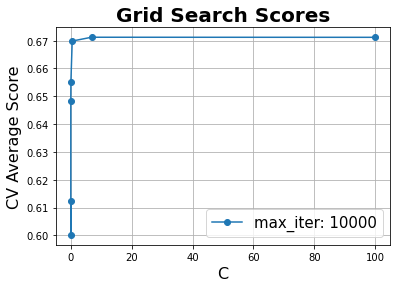

In [10]:
plot_grid_search(grid.cv_results_, params['C'], [10000], 'C', 'max_iter')

In [11]:
grid.best_score_

0.6712304250559284

## Model on PCA data

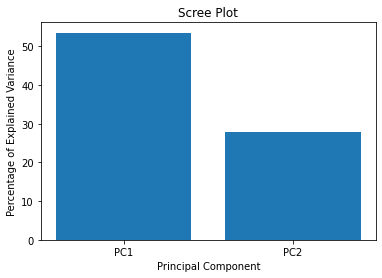

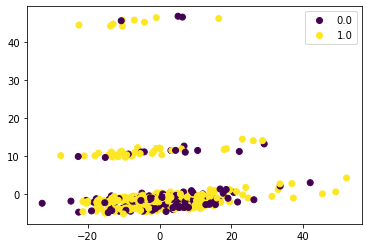

In [12]:
pca = PCA(2)
X_pca = pca.fit_transform(X)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)] 
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

plot = plt.scatter(X_pca[:,0], X_pca[:,1], c=y)
plt.legend(handles=plot.legend_elements()[0], labels=list(y.unique()))
plt.show()

In [13]:
clf = LogisticRegression(penalty = 'l2', max_iter = 1000)

grid = optimise(clf, params, X_pca, y, 0)
grid.best_score_

0.6029082774049217

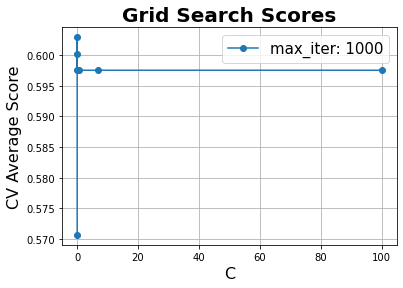

In [14]:
plot_grid_search(grid.cv_results_, params['C'], [1000], 'C', 'max_iter')

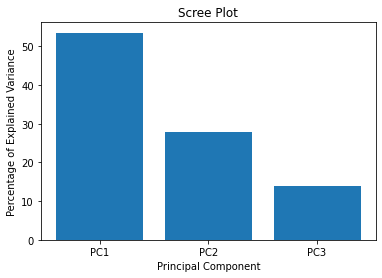

In [15]:
pca = PCA(3)
X_pca = pca.fit_transform(X)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)] 
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

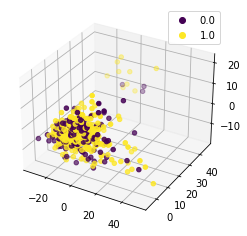

In [16]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c = y)
plt.legend(handles=plot.legend_elements()[0], labels=list(y.unique()))
plt.show()

In [17]:
clf = LogisticRegression(penalty = 'l2', max_iter = 1000)

grid = optimise(clf, params, X_pca, y, 0)
grid.best_score_

0.5961789709172259

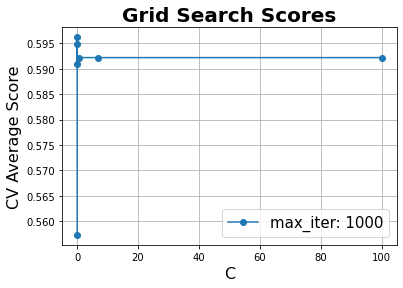

In [18]:
plot_grid_search(grid.cv_results_, params['C'], [1000], 'C', 'max_iter')

## Model on scaled PCA data

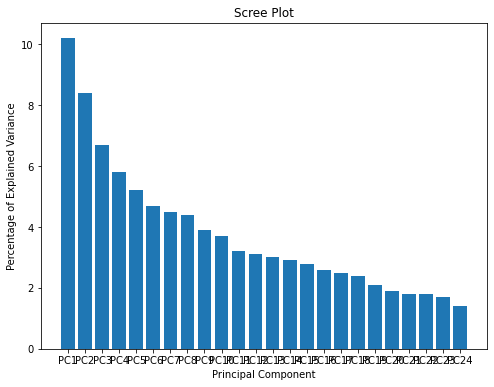

In [19]:
pca = PCA(0.9)
pipe = Pipeline([('scaler', StandardScaler()), ('pca', pca)])
plt.figure(figsize=(8,6))
X_pca = pipe.fit_transform(X)

per_var = np.round(pca.explained_variance_ratio_* 100, decimals=1)
labels = ['PC' + str(x) for x in range(1, len(per_var)+1)] 
plt.bar(x=range(1,len(per_var)+1), height=per_var, tick_label=labels)
plt.ylabel('Percentage of Explained Variance')
plt.xlabel('Principal Component')
plt.title('Scree Plot')
plt.show()

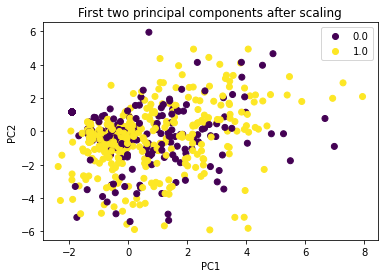

In [20]:
pca_df = pd.DataFrame(X_pca, index = X.index, columns = labels)
plot = plt.scatter(X_pca[:,0], X_pca[:,1], c=y)
legend = list(y.unique())
plt.legend(handles=plot.legend_elements()[0], labels=legend)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("First two principal components after scaling")
#for sample in pca_df.index:
#    plt.annotate(sample, (pca_df.PC1.loc[sample], pca_df.PC2.loc[sample]))
plt.show()

In [46]:
clf = LogisticRegression(penalty = 'l2', max_iter = 1000)

grid = optimise(clf, params, X_pca, y, 0)
grid.best_estimator_

LogisticRegression(C=0.4641588833612782, max_iter=1000)

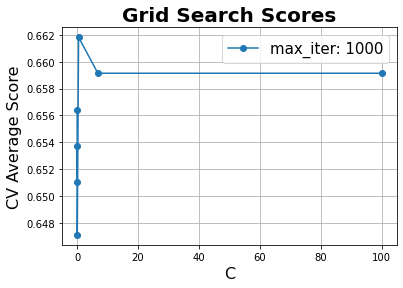

In [22]:
plot_grid_search(grid.cv_results_, params['C'], [1000], 'C', 'max_iter')

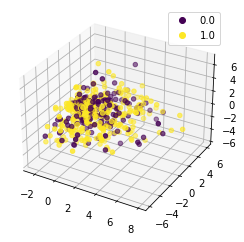

In [23]:
ax = plt.axes(projection='3d')
ax.scatter3D(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c = y)
plt.legend(handles=plot.legend_elements()[0], labels=list(y.unique()))
plt.show()

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3)


est = LogisticRegression(penalty = 'l2', max_iter = 1000)
est.fit(X_train, y_train)
print(est.score(X_train, y_train))
print(est.score(X_test, y_test))

y_pred = est.predict(X_train)
y_pred_test = est.predict(X_test)

print(f1_score(y_pred, y_train, average = "macro"))
print(f1_score(y_pred_test, y_test, average = "macro"))

0.7265774378585086
0.6622222222222223
0.7265774378585086
0.6610908514349136


In [39]:
from sklearn.model_selection import learning_curve

#plot learning curve function from the labs
def plot_learning_curve(n, est, xs, ys, title):
    train_sizes, train_scores, valid_scores = learning_curve(estimator = est, X = xs, y = ys, cv = n)

    train_mean = np.mean(train_scores, axis=1)
    valid_mean = np.mean(valid_scores, axis=1)

    plt.plot(train_sizes, train_mean, color='blue', label='Training Accuracy')
    plt.plot(train_sizes, valid_mean, color='green', label='Validation Accuracy')

    plt.xlabel('Dataset size')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.show()

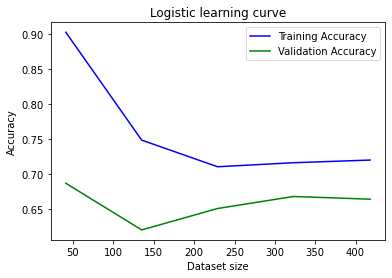

In [47]:
est1 = LogisticRegression(C = 0.4641588833612782, max_iter = 10000)
plot_learning_curve(5, est1 ,X_train, y_train, 'Logistic learning curve')